In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from shapely.geometry import mapping
import rioxarray as rxr
import fiona
import dgl
from dgl.data import DGLDataset
import torch
import networkx as nx
import matplotlib.image as mpimg
import os
# pd.options.mode.chained_assignment = None

# Familiarisation avec les données

## Deux types de données

**Raster**:

* utilise une matrice de zones carrées, des pixels, dont la taille détermine le détail qui peut être conservé dans le jeu de données
* la valeur d'un pixel peut être continue (ex: altitude) ou catégorielle (ex: utilisation des terres)
* décrit l'intérieur des entitiés cartographiques
* utile pour capturer, stocker et analyser des données qui varient continuellement d'un endroit à l'autre (altitude, température, pH du sol, etc.)

**Vector**:

* utilise des coordonnées _x_ et _y_ pour définir la forme et l'emplacement des zones correspondant aux entités cartographiques
* un vecteur peut être un point (ex: point d'intérêt), une ligne (ex: route) ou un polygone (ex: lac)
* décrit le centre et les bords des entités
* utile pour capturer et stocker des détails spatiaux

https://mapasyst.extension.org/what-is-the-difference-between-raster-and-vector-data/#:~:text=Vector%20data%20are%20excellent%20for,store%20aerial%20and%20satellite%20imagery.

https://carpentries-incubator.github.io/geospatial-python/aio/index.html

## De quelles informations disposons-nous ?

Voir _V. Product description_ du manuel d'utilisation, en particulier _V.I.II. Nomenclature_ et _V.II. CLC status layer products_.

## Exploration des données

### Vector

In [ ]:
# clc = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

Impossible de lire tout le fichier _.gpkg_ d'un coup car le programme plante. J'en extrais donc des zones manuellement à l'aide de `QGIS`.


In [ ]:
zones = fiona.listlayers("data/zones/zones.gpkg")
zones

In [ ]:
zone_11_gdf = gpd.read_file("data/zones/zones.gpkg", layer="zone-11")
zone_11_gdf.head()

In [ ]:
zone_11_gdf.info()

In [3]:
legend = pd.read_csv("data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/Legend/clc_legend.csv")
legend.head()

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204


In [ ]:
zone_11_gdf["land_type"] = zone_11_gdf["Code_18"].map(lambda x: legend[legend["CLC_CODE"] == int(x)]["LABEL1"].iloc[0])
zone_11_gdf.head()

In [ ]:
f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.plot(column="land_type", legend=True, ax=ax)
plt.title("Vector layer")
ax.set_axis_off()
plt.show()

#### Codes

In [ ]:
zone_11_gdf["land_type"].value_counts().plot.barh(figsize=(10, 5))
plt.xlabel("Nombre de surfaces", labelpad=10)
plt.title("Nombre de surfaces par catégorie de terrain");

#### Area

In [ ]:
zone_11_gdf.Area_Ha.describe()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.boxplot(zone_11_gdf.Area_Ha)
plt.subplot(122)
plt.boxplot(zone_11_gdf.Area_Ha[zone_11_gdf.Area_Ha < 110])
plt.show()

In [ ]:
zone_11_gdf_area_low = zone_11_gdf[zone_11_gdf.Area_Ha < 125]
zone_11_gdf_area_high = zone_11_gdf[zone_11_gdf.Area_Ha >= 125]

f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf_area_high.plot(ax=ax, color="black", alpha=0.1)
zone_11_gdf_area_low.plot(ax=ax, color="red")
ax.set_axis_off()
plt.title("Surfaces dont l'aire est inférieure à 125 m²")
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.plot(ax=ax, color="black", alpha=0.1)
zone_11_gdf[zone_11_gdf.Area_Ha == max(zone_11_gdf.Area_Ha)].plot(ax=ax, color="red")
ax.set_axis_off()
plt.title("La plus grande surface")
plt.show()

#### Voisins distants et superposés

Vérifions que les surfaces voisines se touchent et ne se superposent pas.

In [ ]:
distanced_dict = {"zone": [], "src": [], "dest": [], "distance": []}
overlapped_dict = {"zone": [], "src": [], "dest": []}

for zone in zones:
    gdf = gpd.read_file("data/zones/zones.gpkg", layer=zone)
    print(f"{zone} ({gdf.shape[0]} instances)", end=" ")

    for index, area in gdf.iterrows():
        distances = gdf.geometry.distance(area.geometry)

        neighbors_d = gdf[(distances < 10) & (distances != 0) & (gdf.OBJECTID != area.OBJECTID)]
        zone_d = [zone] * neighbors_d.shape[0]
        src_d = [area.OBJECTID] * neighbors_d.shape[0]
        dest_d = neighbors_d.OBJECTID.tolist()
        d = distances[neighbors_d.index].tolist()

        distanced_dict["zone"].extend(zone_d)
        distanced_dict["src"].extend(src_d)
        distanced_dict["dest"].extend(dest_d)
        distanced_dict["distance"].extend(d)

        neighbors_o = gdf[(distances == 0) & (gdf.OBJECTID != area.OBJECTID)]
        neighbors_o = neighbors_o[neighbors_o.geometry.overlaps(area.geometry)]
        zone_o = [zone] * neighbors_o.shape[0]
        src_o = [area.OBJECTID] * neighbors_o.shape[0]
        dest_o = neighbors_o.OBJECTID.tolist()

        overlapped_dict["zone"].extend(zone_o)
        overlapped_dict["src"].extend(src_o)
        overlapped_dict["dest"].extend(dest_o)

    print("[ok]")

print("finished")

distanced_df = pd.DataFrame(distanced_dict)
overlapped_df = pd.DataFrame(overlapped_dict)

distanced_df.to_csv("data/zones/distanced.csv")
overlapped_df.to_csv("data/zones/overlapped.csv")

In [ ]:
overlapped_df = pd.read_csv("data/zones/overlapped.csv")
overlapped_df.head()

Sur l'ensemble des données testées, il n'y a pas de surfaces qui se superposent. On considèrera donc qu'il n'y a pas de surfaces qui se superposent sur la totalité du jeu de données pour la suite.

In [ ]:
distanced_df = pd.read_csv("data/zones/distanced.csv")
distanced_df.head()

Il semble y avoir des couples de voisins légèrement éloignés, mais il faut vérifier qu'ils sont effectivement voisins en vérifiant qu'il n'y a pas un autre terrain entre les deux par exemple.

In [ ]:
f = plt.figure(figsize=(20, 90))

i = 0
src = []
for index, neighbors in distanced_df.iterrows():
    if neighbors.dest in src:
        continue

    src.append(neighbors.src)

    # add a new subplot iteratively
    ax = plt.subplot(int(distanced_df.shape[0] / 2) + 1, 2, i + 1)
    i = i + 1

    gdf = gpd.read_file("data/zones/zones.gpkg", layer=neighbors.zone)
    areas = gdf[gdf.OBJECTID.isin([neighbors.src, neighbors.dest])]
    areas.plot("OBJECTID", ax=ax)

    other = gdf[gdf.geometry.touches(areas.iloc[0].geometry)]
    if other.shape[0] > 0:
        other.plot(color="grey", ax=ax, alpha=0.7)

    ax.set_title(f"Voisins {neighbors.src} - {neighbors.dest}")

plt.show()

Les surfaces sont à chaque fois séparées par une autre surface. On considèrera donc qu’il n’y a pas de voisins espacés sur la totalité du jeu de données pour la suite.

### Raster

In [ ]:
attributes = gpd.read_file(
    "data/raw_data/clc/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf")
attributes.head()

Les données raster contiennent les attributs rouge, vert et bleu mais pas infrarouge.

Geopandas ne gère pas les données raster, il faut un outil pour les exploiter: `rioxarray`.

À l'aide de QGIS, j'ai extrait manuellement une zone de la carte complète qui contient celle du jeu de données vectoriel.

In [ ]:
# raster = rxr.open_rasterio('data/zone-11.tif', masked=True).squeeze()
raster = rxr.open_rasterio('data/zones/zone-11.tif').squeeze()

f, ax = plt.subplots(figsize=(14, 5))
raster.plot.imshow(ax=ax)
ax.set(title="Partie du raster centrée sur Paris")
ax.set_axis_off()
plt.show()

**Interrogation**: à quoi servent les autres données (`U2018_CLC2018_V2020_20u1.tif.ovr`, `U2018_CLC2018_V2020_20u1.tfw`...) ?

### Association vector - raster

In [ ]:
f, ax = plt.subplots(figsize=(14, 5))
zone_11_gdf.plot(ax=ax, alpha=.5, color="black")
raster.plot.imshow(ax=ax)
ax.set(title="Complete raster layer with vector overlayed")
ax.set_axis_off()
plt.show()

In [ ]:
raster_clipped = raster.rio.clip(zone_11_gdf.geometry.apply(mapping),
                                 # This is needed if your zone_11_gdf is in a diff CRS than the raster data
                                 zone_11_gdf.crs)

f, ax = plt.subplots(figsize=(14, 7))
raster_clipped.plot(ax=ax)
ax.set(title="Raster layer cropped to geodataframe extent")
ax.set_axis_off()
plt.show()

In [ ]:
test = raster.rio.clip(zone_11_gdf.geometry[1].geoms)

f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.loc[[1], 'geometry'].plot(ax=ax, color="orange", alpha=.6)
test.plot.imshow(ax=ax)
ax.set(title="Raster layer cropped to a specific vector")
ax.set_axis_off()
plt.show()

Les données raster n'ont finalement pas l'air d'ếtre intéressantes à exploiter car on ne dispose pas de données RGB propres à chaque pixel. En effet, il semble que l'on dispose uniquement de valeurs RGB associées de manière générale aux codes CLC.

## Prélèvement automatique de zones géographiques

L'extraction manuelle des zones à l'aide de QGIS est trop fastidieuse, il faut un moyen d'automatiser le processus. En plus, cette méthode n'est pas précise. Geopandas donne la possibilité de charger uniquement une partie du jeu de données complet en fonction de coordonnées données. C'est ce que nous allons utiliser.

Le module GeoPy, intégré au sein de Geopandas, permet de convertir un nom en coordonnées géographiques. À partir de ce point, nous pouvons créer une zone avec un certain rayon et extraire la partie du jeu de données complet qui lui correspond.

Des sites comme http://www.geonames.org/ permettent aussi de récupérer des coordonnées géographiques à partir d'un nom


In [ ]:
paris_location = gpd.tools.geocode("Paris")
paris_location

In [ ]:
paris_area = paris_location.geometry.buffer(10)

In [ ]:
paris_location.crs

In [ ]:
zone_11_gdf.crs

In [ ]:
paris_location_projected = paris_location.to_crs(epsg=3035)

In [ ]:
paris_area = paris_location_projected.geometry.buffer(25000)
paris_area

In [ ]:
f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.plot(ax=ax)
paris_area.exterior.plot(ax=ax, color="orange")
paris_area.plot(ax=ax, color="orange", alpha=0.2)
center = paris_area.geometry.centroid
center.plot(ax=ax, color="black")
plt.annotate("Paris", xy=(center.x, center.y), xytext=(center.x, center.y + 6000), color="black", fontsize=11,
             horizontalalignment="center")
plt.title("Construction d'une surface pour le prélèvement automatique d'une zone")
ax.set_axis_off()
plt.show()

On a réussi à créer une zone à partir d'un nom de ville, on peut maintenant extraire les données correspondantes à partir du jeu de données complet

In [ ]:
paris_gdf = gpd.read_file("data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg",
                          mask=paris_area)

In [ ]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
zone_11_gdf.plot(ax=ax)
ax.set_axis_off()
plt.title("Zone initiale")
ax = plt.subplot(122)
paris_gdf.plot(ax=ax)
plt.title("Zone prélevée automatiquement")
ax.set_axis_off()
plt.show()

On retrouve bien la même région de la carte que celle extraite manuellement.

In [ ]:
def extract_zone(location, area_size, coords=False, data_preprocessing=None,
                 data_path="data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"):
    area = None
    area_radius = np.sqrt(area_size * 1e6 / np.pi)

    if coords is True:
        assert isinstance(location, tuple)
        area = shapely.geometry.Point(location[0], location[1]).buffer(area_radius)

    else:
        location_coords = gpd.tools.geocode(location).to_crs(epsg=3035)
        area = location_coords.geometry.buffer(area_radius)

    gdf = gpd.read_file(data_path, mask=area)
    if data_preprocessing is not None:
        gdf = data_preprocessing(gdf)

    return gdf

## Vérification des longueurs

Vérifions les longueurs calculées par geopandas sur une zone dont on connait les dimensions. Par exemple, le lac d'Annecy:

* Périmètre : 38 km
* Aire :  26.5 km²

In [ ]:
f, ax = plt.subplots(figsize=(14, 7))
gdf = extract_zone("Lac d'Annecy", 1)
gdf.plot(ax=ax)
ax.set_axis_off()
plt.title("Lac d'Annecy")
plt.show()

In [ ]:
lac_annecy = gdf.iloc[0]
code = lac_annecy.Code_18
label = attributes[attributes.CODE_18 == code].iloc[0].LABEL3
print(f"{code} - {label}")

In [ ]:
print(f"Aire calculée: {round(lac_annecy.geometry.area / 1e6, 1)} km²")
print(f"Périmètre calculé: {round(lac_annecy.geometry.length / 1e3, 1)} km")

In [ ]:
print(f"Aire - écart : {round((abs(26.5 - lac_annecy.geometry.area / 1e6) / 26.5) * 100, 2)} %")
print(f"Périmètre - écart : {round((abs(38 - lac_annecy.geometry.length / 1e3) / 38) * 100, 2)} %")

Les longueurs calculées correspondent aux longueurs attendues. On pourra donc s'en servir pour l'apprentissage.

# Création des jeux de données pour la classification des graphes

## Capitales et campagnes

J'ai recensé des grandes capitales d'Europe de taille similaire.

In [ ]:
countries = ["Allemagne", "Espagne", "Finlande", "France", "Italie", "Pologne", "Roumanie", "Royaume-Uni", "Suède"]
capitals = ["Berlin", "Madrid", "Helsinki", "Paris", "Rome", "Varsovie", "Bucarest", "Londres", "Stockholm"]

J'ai également récupéré manuellement des coordonnées se trouvant dans des vastes zones rurales à travers l'Europe.

In [ ]:
campaigns_coords = pd.read_csv("data/capitales-campagnes/campaigns_coords.csv")
campaigns_coords.info()

### Extraction des zones de la BD Corine Land Cover

L'objectif est de récupérer des zones qui représentent au mieux le type de terrain qu'on souhaite extraire (urbain pour les capitales et rural pour les campagnes). Ainsi, on ne souhaite pas inclure des parcelles représentant des zones rurales pour les capitales et des zones urbaines pour les campagnes. Il faut donc choisir une taille de zone assez grande pour avoir un nombre d'instances suffisant pour l'apprentissage, mais pas trop grande pour ne pas récupérer la périphérie de ce que l'on veut extraire.

In [ ]:
land_types = legend["LABEL1"].unique().tolist()

In [ ]:
def test_extraction_sizes(locations, area_sizes, plot=True, coords=False, data_preprocessing=None,
                          locations_labels=None):
    nb_locations = len(locations)
    nb_sizes = len(area_sizes)

    category_counts_dict = {category: np.zeros(nb_locations) for category in
                            ["nb_areas", "total_size", "avg_area_size"] + land_types}
    avg_counts_dict = {category: np.zeros(nb_sizes) for category in
                       ["total_nb_areas", "avg_nb_areas", "avg_total_size", "avg_area_size"] + land_types}

    if plot is True:
        plt.figure(figsize=(20, 15))

    for j in range(nb_sizes):
        print(f"size={area_sizes[j]}", end=" ")

        for i in range(nb_locations):
            gdf = extract_zone(locations[i], area_size=area_sizes[j], coords=coords,
                               data_preprocessing=data_preprocessing)

            nb_instances = len(gdf)
            counts = gdf["land_type"].value_counts()

            for category, count in counts.iteritems():
                category_counts_dict[category][i] = round(count / nb_instances, 2)

            category_counts_dict["nb_areas"][i] = nb_instances
            category_counts_dict["total_size"][i] = round(gdf.dissolve().area / 1e6, 2)
            category_counts_dict["avg_area_size"][i] = round(gdf.area.median() / 1e6, 2)

        category_counts_df = pd.DataFrame(category_counts_dict, index=locations_labels)
        category_counts_df["nb_areas"] = category_counts_df["nb_areas"].astype(int)

        if plot is True:
            if j > 0 and j % 6 == 0:
                plt.show()
                plt.figure(figsize=(20, 15))

            ax = plt.subplot(3, 2, (j % 6) + 1)
            category_counts_df.iloc[:, 3:].plot.barh(ax=ax, stacked=True)
            plt.legend(loc='lower left')
            plt.title(f"A = {area_sizes[j]} km²")

        avg_counts_dict["total_nb_areas"][j] = category_counts_df["nb_areas"].sum()
        avg_counts_dict["avg_nb_areas"][j] = int(category_counts_df["nb_areas"].mean())
        avg_counts_dict["avg_total_size"][j] = round(category_counts_df["total_size"].mean(), 2)
        avg_counts_dict["avg_area_size"][j] = round(category_counts_df["avg_area_size"].mean(), 2)

        for category in category_counts_df.iloc[:, 3:]:
            avg_counts_dict[category][j] = round(category_counts_df[category].mean(), 2)

        print("[ok]", end=" | ")

    if plot is True:
        plt.show()

    avg_counts_df = pd.DataFrame(avg_counts_dict, index=area_sizes)
    avg_counts_df["total_nb_areas"] = avg_counts_df["total_nb_areas"].astype(int)
    avg_counts_df["avg_nb_areas"] = avg_counts_df["avg_nb_areas"].astype(int)

    return avg_counts_df

#### Capitales

In [ ]:
capitals_location = [f"{capitals[i]}, {countries[i]}" for i in range(len(capitals))]
capitals_location

In [ ]:
def data_preprocessing(gdf, legend_path="data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/Legend/clc_legend.csv"):
    legend = pd.read_csv(legend_path)
    gdf["land_type"] = gdf["Code_18"].map(lambda x: legend[legend["CLC_CODE"] == int(x)]["LABEL1"].iloc[0])
    return gdf


avg_counts_df = test_extraction_sizes(capitals_location, area_sizes=range(10, 70, 10),
                                      data_preprocessing=data_preprocessing,
                                      locations_labels=capitals, plot=True)
avg_counts_df

Nous pourrons prendre une taille d'extraction entre 20 et 30 km² pour maximiser le taux de parcelles urbaines dans le jeu de données tout en conservant un nombre important d'instances. Il sera peut-être nécessaire, en fonction des résultats de l'apprentissage, d'augmenter ce rayon ou d'utiliser plus de villes pour avoir plus d'instances.

#### Campagnes

In [ ]:
campaigns_location = list(zip(campaigns_coords.X, campaigns_coords.Y))
campaigns_location[:5]

In [ ]:
avg_counts_df = test_extraction_sizes(campaigns_location, area_sizes=range(10, 70, 10),
                                      data_preprocessing=data_preprocessing,
                                      coords=True, plot=False)
avg_counts_df

La répartition des catégories de parcelle en fonction du rayon d'extraction des zones est plutôt uniforme. Cela s'explique car les campagnes sont en général plus vastes et uniformes que les villes. Elles semblent donc poser moins de problème.

On considèrera donc uniquement la contrainte imposée par les villes et on prendra une taille d'extraction de 20 km².

### Enregistrement des données

In [ ]:
def cap_camp_preprocessing(gdf):
    # gdf = gdf[~gdf["Code_18"].isin(["122", "511", "523"])]  # suppression des routes, cours d'eau, mer et océan
    gdf["Node_ID"] = range(len(gdf))  # pour simplifier la création des graphes
    # todo : gérer les codes 18
    # todo : gérer les nodata
    return gdf


area_size = 20

# capitales
for i in range(len(capitals)):
    gdf = extract_zone(capitals_location[i], area_size=area_size, coords=False,
                       data_preprocessing=cap_camp_preprocessing)
    gdf.to_file("data/capitales-campagnes/data.gpkg", driver="GPKG", layer=capitals[i])

# campagnes
for i in range(len(campaigns_coords)):
    gdf = extract_zone(campaigns_location[i], area_size=area_size, coords=True,
                       data_preprocessing=cap_camp_preprocessing)
    gdf.to_file("data/capitales-campagnes/data.gpkg", driver="GPKG", layer=f"Camp-{i}")

## Communes d'Europe

Objectif : classification du territoire européen à partir de graphes

### Sélection des communes

Utiliser la base de données GISCO pour sélectionner environ 5000 communes ayant une superficie proche.

In [4]:
communes_gdf = gpd.read_file("data/raw_data/communes-euro/COMM_RG_01M_2016_3035.shp")

In [5]:
communes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 122750 entries, 0 to 122749
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   COMM_ID    122750 non-null  object  
 1   CNTR_ID    122750 non-null  object  
 2   CNTR_CODE  122749 non-null  object  
 3   COMM_NAME  122749 non-null  object  
 4   NAME_ASCI  122749 non-null  object  
 5   TRUE_FLAG  120583 non-null  object  
 6   NSI_CODE   120577 non-null  object  
 7   NAME_NSI   120149 non-null  object  
 8   NAME_LATN  122749 non-null  object  
 9   NUTS_CODE  120577 non-null  object  
 10  FID        122750 non-null  object  
 11  geometry   122750 non-null  geometry
dtypes: geometry(1), object(11)
memory usage: 11.2+ MB


In [6]:
communes_gdf.head()

,COMM_ID,CNTR_ID,CNTR_CODE,COMM_NAME,NAME_ASCI,TRUE_FLAG,NSI_CODE,NAME_NSI,NAME_LATN,NUTS_CODE,FID,geometry
0,AL0734,AL,AL,Pogradec,Pogradec,None,None,None,Pogradec,None,AL0734,"POLYGON ((5234384.813 2037413.214, 5231405.488..."
1,AL0735,AL,AL,Maliq,Maliq,None,None,None,Maliq,None,AL0735,"POLYGON ((5201749.637 2008471.011, 5199770.168..."
2,AL0736,AL,AL,Pustec,Pustec,None,None,None,Pustec,None,AL0736,"MULTIPOLYGON (((5234384.813 2037413.214, 52354..."
3,AL0737,AL,AL,Kolonjë,Kolonje,None,None,None,Kolonje,None,AL0737,"POLYGON ((5234331.624 1998545.391, 5235129.050..."
4,AL0738,AL,AL,Devoll,Devoll,None,None,None,Devoll,None,AL0738,"POLYGON ((5242658.644 2025967.847, 5242693.791..."


In [7]:
communes_gdf["surf_km2"] = communes_gdf['geometry'].area / 1e6
communes_gdf['surf_km2'].describe()

count    122750.000000
mean         64.307153
std        3424.952261
min           0.000926
25%           6.597038
50%          14.692228
75%          33.090821
max      889250.031201
Name: surf_km2, dtype: float64

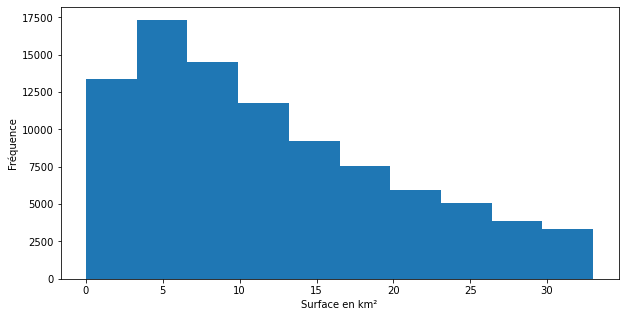

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(communes_gdf[communes_gdf["surf_km2"] < 33]["surf_km2"])
plt.ylabel("Fréquence")
plt.xlabel("Surface en km²")
plt.show()

Je sélectionne des communes dont la taille n'est pas trop petite pour avoir plus de chance de voir des zones urbaines dans la BD CLC. Nous prendrons donc des communes de taille comprise entre 25 et 30 km².

In [9]:
communes_selected = communes_gdf[(communes_gdf['surf_km2'] > 25) & (communes_gdf['surf_km2'] < 30)]
communes_selected.describe()

,surf_km2
count,6260.000000
mean,27.333882
std,1.438020
min,25.000174
25%,26.065479
50%,27.265835
75%,28.543571
max,29.999269


In [10]:
communes_fr = communes_selected[communes_gdf['CNTR_ID'] == 'FR']
communes_other = communes_selected[communes_gdf['CNTR_ID'] != 'FR']

/home/massimo/anaconda3/envs/graph/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/massimo/anaconda3/envs/graph/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [11]:
communes_fr['surf_km2'].describe()

count    1661.000000
mean       27.273257
std         1.413639
min        25.014109
25%        26.028388
50%        27.190616
75%        28.420457
max        29.993751
Name: surf_km2, dtype: float64

In [12]:
communes_other['surf_km2'].describe()

count    4599.000000
mean       27.355777
std         1.446252
min        25.000174
25%        26.089207
50%        27.284208
75%        28.573450
max        29.999269
Name: surf_km2, dtype: float64

### Extraction des zones de la BD Corine Land Cover

#### Comparaison des BD Corine Land Cover et Communes


Regardons s'il est possible d'utiliser les surfaces des communes pour extraire les zones correspondantes dans la BD Corine Land Cover.

Pour ce faire, comparons le positionnement des surfaces des communes avec celles de Corine Land Cover.


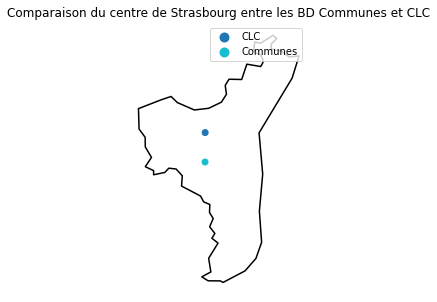

Distance entre les deux centres : 2021 m


In [13]:
strasbourg_communes = communes_gdf[communes_gdf['COMM_NAME'] == 'Strasbourg']
strasbourg_loc = gpd.tools.geocode("Strasbourg, France").to_crs(3035)

f, ax = plt.subplots(figsize=(10, 5))
strasbourg_communes.boundary.plot(ax=ax, color="black")
points_gdf = gpd.GeoDataFrame({"class": ["Communes", "CLC"],
                               "geometry": [strasbourg_communes.representative_point().iloc[0],
                                            strasbourg_loc.iloc[0].geometry]})
points_gdf.plot("class", legend=True, ax=ax)
ax.set_axis_off()
plt.title("Comparaison du centre de Strasbourg entre les BD Communes et CLC")
plt.show()

d = strasbourg_communes.representative_point().distance(strasbourg_loc.iloc[0].geometry).iloc[0]
print(f"Distance entre les deux centres : {int(d)} m")

Nous pouvons considérer que le positionnement des surfaces des communes coincide avec celles de Corine Land Cover. Ainsi, nous pouvons nous servir des surfaces des communes pour directement extraire les zones de la BD Corine Land Cover.

#### Extraction à partir de la BD Communes

Essayons d'extraire de la BD CLC la commune de Strasbourg à partir de la surface présente dans la BD Commune.

In [14]:
clc_path = "data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"

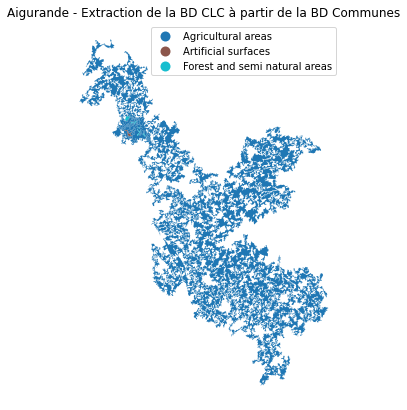

In [15]:
commune = communes_fr.iloc[1]
commune_clc = gpd.read_file(clc_path, mask=commune["geometry"])
commune_clc["land_type"] = commune_clc["Code_18"].map(lambda x: legend[legend["CLC_CODE"] == int(x)]["LABEL1"].iloc[0])

f, ax = plt.subplots(figsize=(14, 7))
commune_clc.plot("land_type", legend=True, ax=ax)
ax.set_axis_off()
plt.title(f"{commune['COMM_NAME']} - Extraction de la BD CLC à partir de la BD Communes")
plt.show()

Le résultat n'est pas convaincant. Les aires de la BD de CLC peuvent être très grandes, ce qui peut entraîner l'extraction de plus d'information que celles concernant la commune souhaitée. Cela peut représenter un biais pour l'apprentissage.

Découpons la zone extraite à partir de la surface de la commune.

In [16]:
commune_clc_cropped = commune_clc.clip(commune["geometry"])

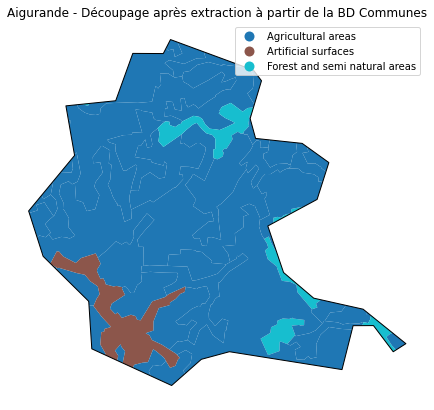

In [17]:
exterior = commune_clc_cropped.dissolve().exterior

f, ax = plt.subplots(figsize=(14, 7))
exterior.plot(ax=ax, color="black", linewidth=1)
commune_clc_cropped.plot("land_type", legend=True, ax=ax)
# gdf.representative_point().plot(ax=ax, color="black", alpha=0.5)
plt.title(f"{commune['COMM_NAME']} - Découpage après extraction à partir de la BD Communes")
ax.set_axis_off()
plt.show()

### Redéfinition des aires coupées

Le découpage des aires de CLC peut en séparer certaines en plusieurs parties distinctes. On souhaite alors les décomposer en instances séparées.

In [18]:
multipolygons = commune_clc_cropped[commune_clc_cropped["geometry"].geom_type == "MultiPolygon"]
multipolygons.head()

,Code_18,Remark,Area_Ha,ID,geometry,land_type
25,231,None,20400.734222,EU_596798,"MULTIPOLYGON (((3692549.740 2629348.820, 36925...",Agricultural areas
11,242,None,52.268585,EU_432579,"MULTIPOLYGON (((3691861.420 2628316.350, 36918...",Agricultural areas
0,231,None,1302.041071,EU_423461,"MULTIPOLYGON (((3694094.430 2625092.940, 36941...",Agricultural areas
10,231,None,608.549877,EU_423484,"MULTIPOLYGON (((3691898.100 2627812.890, 36920...",Agricultural areas
4,242,None,55.890400,EU_432500,"MULTIPOLYGON (((3693793.220 2625203.690, 36938...",Agricultural areas


Nous pouvons décomposer les `MultiPolygon` en autant d'instances que de `Polygon` qui les composent.

In [19]:
commune_clc_exp = commune_clc_cropped.explode(index_parts=False)

In [20]:
commune_clc_exp["geometry"].geom_type.value_counts()

Polygon    51
dtype: int64

In [21]:
commune_clc_exp[commune_clc_exp["ID"] == "EU_596779"]

,Code_18,Remark,Area_Ha,ID,land_type,geometry


De cette manière, nous gardons en plus la trace du "parent" des sous-aires construites.

In [22]:
ids = multipolygons["ID"].tolist()
new_polygons = commune_clc_exp[commune_clc_exp["ID"].isin(ids)]

In [23]:
def plot_map_num(gdf, ax):
    gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf['coords'] = [coords[0] for coords in gdf['coords']]

    gdf.plot(np.array(range(0, len(gdf))), ax=ax)

    gdf.representative_point().plot(ax=ax, alpha=0.7, color="black", markersize=280)

    for idx, row in gdf.iterrows():
        plt.annotate(idx, xy=row['coords'], horizontalalignment='center', verticalalignment='center', color="white")

    ax.set_axis_off()

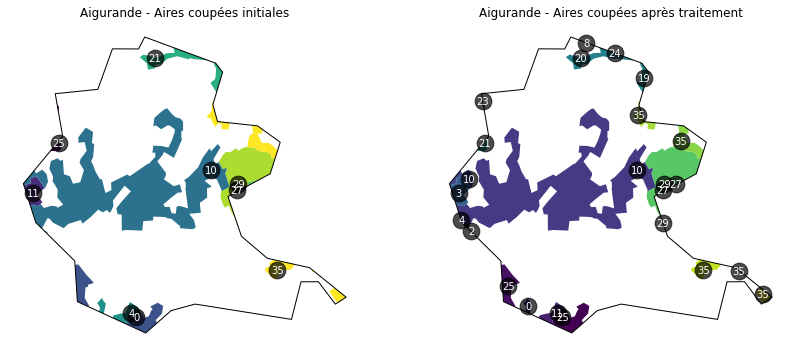

In [24]:
plt.figure(figsize=(14, 7))

ax = plt.subplot(121)
exterior.plot(ax=ax, color="black", linewidth=1)
plot_map_num(multipolygons, ax)
plt.title(f"{commune['COMM_NAME']} - Aires coupées initiales")

ax = plt.subplot(122)
exterior.plot(ax=ax, color="black", linewidth=1)
plot_map_num(new_polygons, ax)
plt.title(f"{commune['COMM_NAME']} - Aires coupées après traitement")

plt.show()

### Suppression des aires résiduelles après découpage

En découpant les aires de CLC, des petites aires résiduelles sont présentes aux extrémités de la carte. Deux possibilités : laisser comme tel ou les supprimer.

Voyons le résultat qu'on peut obtenir si on supprime les petites aires résiduelles suite au découpage des aires de CLC.

In [25]:
commune_clc["total_area"] = commune_clc.area
commune_clc = commune_clc.drop("Area_Ha", axis="columns")

commune_clc_clipped = commune_clc.clip(commune["geometry"])
commune_clc_clipped = commune_clc_clipped.explode(index_parts=False)
commune_clc_clipped["object_proportion"] = commune_clc_clipped.area / commune_clc_clipped["total_area"]
commune_clc_clipped["total_proportion"] = commune_clc_clipped.area / commune_clc_clipped.area.sum()

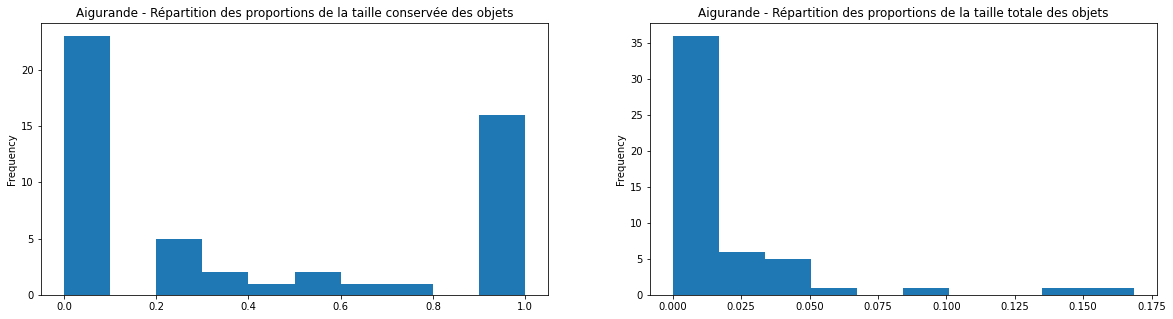

In [26]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(121)
commune_clc_clipped["object_proportion"].plot.hist(ax=ax)
plt.title(f"{commune['COMM_NAME']} - Répartition des proportions de la taille conservée des objets")

ax = plt.subplot(122)
commune_clc_clipped["total_proportion"].plot.hist(ax=ax)
plt.title(f"{commune['COMM_NAME']} - Répartition des proportions de la taille totale des objets")

plt.show()

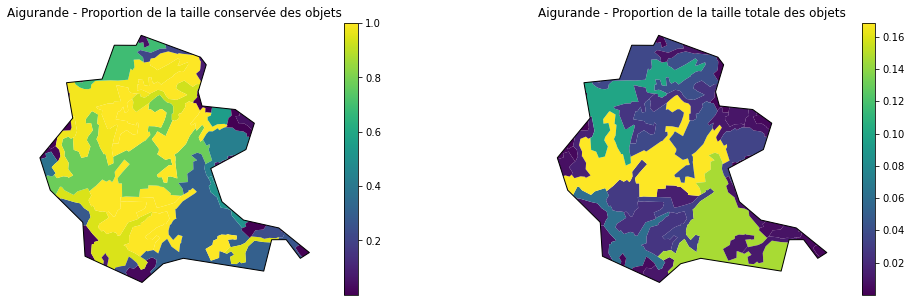

In [27]:
plt.figure(figsize=(17, 5))

ax = plt.subplot(121)
exterior.plot(ax=ax, color="black", linewidth=1)
commune_clc_clipped.plot("object_proportion", legend=True, ax=ax)
ax.set_axis_off()
plt.title(f"{commune['COMM_NAME']} - Proportion de la taille conservée des objets")

ax = plt.subplot(122)
exterior.plot(ax=ax, color="black", linewidth=1)
commune_clc_clipped.plot("total_proportion", legend=True, ax=ax)
ax.set_axis_off()
plt.title(f"{commune['COMM_NAME']} - Proportion de la taille totale des objets")

plt.show()

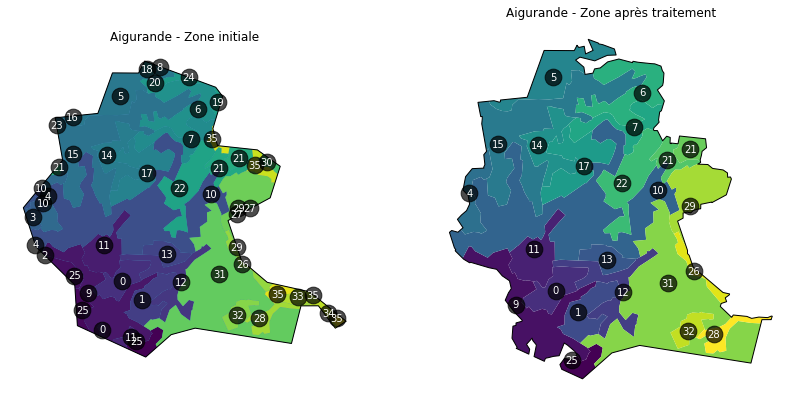

In [28]:
residus = commune_clc_clipped[
    (commune_clc_clipped["object_proportion"] < 0.50) & (commune_clc_clipped["total_proportion"] < 0.01)]
communes_clc_bis = commune_clc_clipped[
    (commune_clc_clipped["object_proportion"] >= 0.50) | (commune_clc_clipped["total_proportion"] >= 0.01)]

plt.figure(figsize=(14, 7))

ax = plt.subplot(121)
exterior.plot(ax=ax, color="black", linewidth=1)
commune_clc_clipped.plot(ax=ax)
plot_map_num(commune_clc_clipped, ax=ax)
plt.title(f"{commune['COMM_NAME']} - Zone initiale")

ax = plt.subplot(122)
communes_clc_bis.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
plot_map_num(communes_clc_bis, ax=ax)
plt.title(f"{commune['COMM_NAME']} - Zone après traitement")

plt.show()

Le résultat semble intéressant. Nous utiliserons cette méthode d'extraction pour l'apprentissage.

#### Enregistrement des données

In [71]:
def communes_preprocessing(gdf, rm_residual_areas=True, object_prop_th=0.50, total_prop_th=0.01):
    # todo : gérer les codes 18
    # todo : gérer les nodata
    gdf["total_area"] = gdf.area
    gdf = gdf.drop("Area_Ha", axis="columns")

    gdf = gdf.explode(index_parts=False)
    gdf["object_proportion"] = gdf.area / gdf["total_area"]
    gdf["total_proportion"] = gdf.area / gdf.area.sum()

    if rm_residual_areas is True:
        gdf = gdf[(gdf["object_proportion"] >= object_prop_th) | (gdf["total_proportion"] >= total_prop_th)]

    gdf["Node_ID"] = range(len(gdf))  # pour simplifier la création des graphes
    return gdf

total instances :  6260


KeyboardInterrupt: 

In [ ]:
# jeu de données complet
# print("total instances : ", len(communes_selected))
# i = 1
# for index, commune in communes_selected.iterrows():
#     if i%100 == 0:
#         print(i, end="...")
#     i+=1
#     gdf = gpd.read_file(clc_path, mask=commune["geometry"])
#     if len(gdf) != 0:
#         # si la donnée est manquante, c'est qu'il s'agit des DOM
#         gdf = gdf.clip(commune["geometry"])
#         gdf = communes_preprocessing(gdf)
#         gdf.to_file("data/communes/communes_clc.gpkg", driver="GPKG", layer=commune["COMM_ID"])

In [79]:
# petit échantillon pour les tests
for index, commune in communes_fr.sample(frac = 1).iloc[:100].iterrows():
    gdf = gpd.read_file(clc_path, mask=commune["geometry"])
    if len(gdf) != 0:
        # si la donnée est manquante, c'est qu'il s'agit des DOM
        gdf = gdf.clip(commune["geometry"])
        gdf = communes_preprocessing(gdf)
        gdf.to_file("data/communes/communes_clc.gpkg", driver="GPKG", layer=commune["COMM_ID"])

# petit échantillon pour les tests
for index, commune in communes_other.sample(frac = 1).iloc[:100].iterrows():
    gdf = gpd.read_file(clc_path, mask=commune["geometry"])
    if len(gdf) != 0:
        # si la donnée est manquante, c'est qu'il s'agit des DOM
        gdf = gdf.clip(commune["geometry"])
        gdf = communes_preprocessing(gdf)
        gdf.to_file("data/communes/communes_clc.gpkg", driver="GPKG", layer=commune["COMM_ID"])

# Construction des graphes

## Calcul du voisinage

In [73]:
def preprocess_border(border):
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border


def calc_borders(area, neighbors):
    borders_info = {"total_border": [], "greatest_border": [], "nb_borders": []}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info


def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]

        src = [area.Node_ID] * neighbors.shape[0]
        dest = neighbors.Node_ID.tolist()

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

## Création des graphes

In [74]:
def generate_graph_data(data_path):
    layers = fiona.listlayers(data_path)
    graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [],
                        "nb_borders": []}
    graph_properties_dict = {"graph_id": [], "num_nodes": []}

    for i in range(len(layers)):
        print(layers[i], end=" ")
        gdf = gpd.read_file(data_path, layer=layers[i])
        neighbors = calc_neighbors(gdf)

        graph_properties_dict["graph_id"].append(layers[i])
        graph_properties_dict["num_nodes"].append(len(gdf))

        graph_edges_dict["src"].extend(neighbors["src"])
        graph_edges_dict["dest"].extend(neighbors["dest"])
        graph_edges_dict["total_border"].extend(neighbors["total_border"])
        graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
        graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
        graph_edges_dict["graph_id"].extend([layers[i]] * len(neighbors["src"]))

        print("[ok]", end=" | ")

    graph_edges_df = pd.DataFrame(graph_edges_dict)
    graph_properties_df = pd.DataFrame(graph_properties_dict)

    return graph_edges_df, graph_properties_df

In [57]:
# capitales-campagnes
# graph_edges_df, graph_properties_df = generate_graph_data("data/capitales-campagnes/data.gpkg")
# # graph_properties_df["label"] = int(graph_properties_df["label"] in capitals)
# graph_edges_df.to_csv("data/capitales-campagnes/graph_edges.csv")
# graph_properties_df.to_csv("data/capitales-campagnes/graph_properties.csv")

In [80]:
# communes
graph_edges_df, graph_properties_df = generate_graph_data("data/communes/communes_clc.gpkg")
graph_properties_df["label"] = graph_properties_df["graph_id"].map(lambda graph_id: graph_id[:2] == 'FR')
graph_edges_df.to_csv("data/communes/graph_edges.csv")
graph_properties_df.to_csv("data/communes/graph_properties.csv")

FR75244050 [ok] | FR44552184 [ok] | FR24364121 [ok] | FR27583028 [ok] | FR53351068 [ok] | FR24453228 [ok] | FR76811241 [ok] | FR24451279 [ok] | FR93043203 [ok] | FR75232096 [ok] | FR84033205 [ok] | FR27715231 [ok] | FR76652058 [ok] | FR75641273 [ok] | FR24364230 [ok] | FR76123111 [ok] | FR75243266 [ok] | FR27213271 [ok] | FR53224015 [ok] | FR53224277 [ok] | FR44686315 [ok] | FR75163393 [ok] | FR84151146 [ok] | FR75242582 [ok] | FR75243309 [ok] | FR75333523 [ok] | FR44553014 [ok] | FR53224345 [ok] | FR52721376 [ok] | FR52443182 [ok] | FR27582058 [ok] | FR75641543 [ok] | FR44551389 [ok] | FR84262369 [ok] | FR24411017 [ok] | FR27701240 [ok] | FR75641102 [ok] | FR75872032 [ok] | FR24411262 [ok] | FR27583144 [ok] | FR24182054 [ok] | FR75172434 [ok] | FR76122093 [ok] | FR24284261 [ok] | FR76482137 [ok] | FR84381565 [ok] | FR44511117 [ok] | FR27701404 [ok] | FR52533144 [ok] | FR75191274 [ok] | FR52492070 [ok] | FR53293113 [ok] | FR44514340 [ok] | FR75862117 [ok] | FR75243139 [ok] | FR84381322

In [82]:
# DGL dataset
class GraphClassDataset(DGLDataset):
    def __init__(self, edges_path, properties_path, data_path):
        self.edges = pd.read_csv(edges_path)
        self.properties = pd.read_csv(properties_path)
        self.data_path = data_path
        self.graphs = []
        self.labels = []
        self.ids = []
        super().__init__(name='synthetic')

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = self.edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            src = edges_of_id.src.to_numpy()
            dest = edges_of_id.dest.to_numpy()
            g = dgl.graph((src, dest), num_nodes=num_nodes)

            data = gpd.read_file(self.data_path, layer=graph_id)

            # g.ndata['label'] = torch.from_numpy(data.OBJECTID.to_numpy())
            g.ndata['area'] = torch.from_numpy(data.area.to_numpy())
            g.ndata['code'] = torch.from_numpy(data["Code_18"].astype(int).to_numpy())
            g.edata['total_border'] = torch.from_numpy(edges_of_id.total_border.to_numpy())
            g.edata['greatest_border'] = torch.from_numpy(edges_of_id.greatest_border.to_numpy())
            g.edata['nb_borders'] = torch.from_numpy(edges_of_id.nb_borders.to_numpy())

            points = data.representative_point()  # pour la visualisation
            g.ndata['pos'] = torch.as_tensor(list(zip(points.geometry.x, points.geometry.y)))

            self.graphs.append(g)
            self.labels.append(label)
            self.ids.append(graph_id)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i], self.ids[i]

    def __len__(self):
        return len(self.graphs)

    def get_graphs(self):
        return self.graphs

    def get_labels(self):
        return self.labels

    def get_ids(self):
        return self.ids

In [ ]:
communes_graph_dataset = GraphClassDataset("data/communes/graph_edges.csv", "data/communes/graph_properties.csv",
                                         "data/communes/communes_clc.gpkg")

## Visualisation des graphes

In [83]:
def draw_map_graph(graph, gdf, column=None, legend=False, ax=None):
    g_nx = dgl.to_networkx(graph, node_attrs=graph.ndata.keys(), edge_attrs=graph.edata.keys()).to_undirected()
    pos = nx.get_node_attributes(g_nx, 'pos')
    for key in pos:
        pos[key] = tuple(pos[key].tolist())

    gdf.plot(column, legend=legend, ax=ax)
    nx.draw(g_nx, pos=pos, with_labels=True, ax=ax, node_color=[(0, 0, 0, 0.7)], font_color="white")

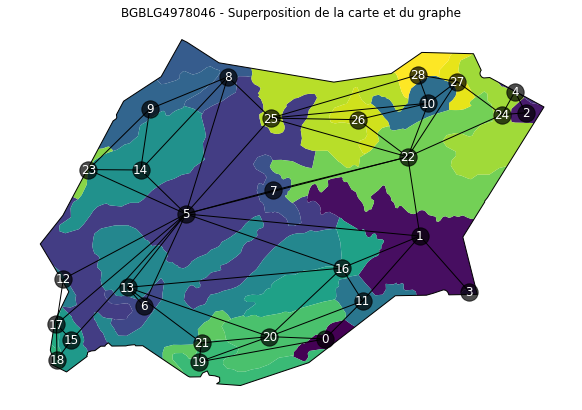

In [109]:
graph, label, id = communes_graph_dataset[5]
f, ax = plt.subplots(figsize=(14, 7))
gdf = gpd.read_file("data/communes/communes_clc.gpkg", layer=id)
gdf.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
draw_map_graph(graph, gdf=gdf, column=np.array(range(len(gdf))), ax=ax)
plt.title(f"{id} - Superposition de la carte et du graphe")
plt.show()

In [ ]:
### exportations

## graphviz
# path = './a.out.png'
#
# ag = nx.nx_agraph.to_agraph(g_nx)
# ag.layout()
# ag.draw(path)
#
# img = mpimg.imread(path)
# plt.figure(figsize=(10,5))
# plt.imshow(img)
# plt.title(label)
# plt.show()
#
# os.remove(path)

## graphml
# nx.write_graphml(g_nx, "test.graphml") # peut être utilisé avec cytoscape

## dot
# nx.drawing.nx_agraph.write_dot(g_nx, "test.dot") # dot file

# Classification de graphes

## Graph embedding

In [112]:
# karate club: https://karateclub.readthedocs.io/en/latest/index.html
import karateclub as kc

graphs = [dgl.to_networkx(graph, node_attrs=graph.ndata.keys(), edge_attrs=graph.edata.keys()).to_undirected() for graph in communes_graph_dataset.get_graphs()]
graph2vec = kc.Graph2Vec()
graph2vec.fit(graphs)

In [131]:
vec_dataset = graph2vec.get_embedding()
vec_dataset = pd.DataFrame(vec_dataset)
vec_dataset['id'] = communes_graph_dataset.get_ids()
vec_dataset['Y'] = communes_graph_dataset.get_labels()
vec_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,id,Y
0,0.010929,0.006350,0.000333,-0.000998,-0.004580,-0.005686,0.000369,-0.001511,-0.008973,-0.007525,...,0.001203,0.002015,0.004209,0.005628,-0.001501,0.007374,0.003388,0.004489,AT40445,0
1,0.005679,0.006853,-0.007143,0.003392,0.006755,-0.003778,0.002474,-0.004003,-0.010368,0.000345,...,0.002159,0.006416,0.004070,0.002387,-0.006462,-0.001724,0.004114,-0.001299,BE236008,0
2,0.021794,-0.004371,-0.026818,0.024682,0.014688,-0.012846,0.014775,-0.022882,-0.018162,-0.000849,...,-0.011777,-0.007139,0.003854,-0.008533,0.005620,0.003010,-0.007320,0.005991,BE273098,0
3,0.011504,-0.006963,-0.011185,0.001924,-0.002100,-0.002605,0.007740,-0.014192,-0.012833,-0.000783,...,-0.002926,0.000019,-0.003243,-0.008245,0.000511,0.005736,-0.001516,-0.001690,BGBGS2161114,0
4,0.013740,-0.007171,-0.017082,0.008931,0.005817,-0.003516,0.009238,-0.014734,-0.002388,-0.006807,...,-0.007522,-0.004419,0.000720,0.004661,0.005421,0.002825,-0.003915,-0.006151,BGBGS2327615,0


# Backup - classification de noeuds

In [ ]:
# class NodeClassificationDataset(DGLDataset):
#     def __init__(self):
#         super().__init__(name='karate_club')
#
#     def process(self):
#         # nodes_data = gpd.read_file("data/zone-11-preprocessed.gpkg")
#         # neighborhood = pd.read_csv("data/zone-11-neighborhood.csv")
#
#         src_nodes = neighborhood.src
#         dest_nodes = neighborhood.dest
#         num_nodes = nodes_data.shape[0]
#
#         self.graph = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)
#
#         self.graph.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
#         self.graph.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
#         self.graph.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
#         self.graph.edata['total_border'] = torch.from_numpy(neighborhood.total_border.to_numpy())
#         self.graph.edata['greatest_border'] = torch.from_numpy(neighborhood.greatest_border.to_numpy())
#         self.graph.edata['nb_border'] = torch.from_numpy(neighborhood.nb_border.to_numpy())
#
#         # masks indicating whether a node belongs to training, validation, and test set
#         n_train = int(num_nodes * 0.6)
#         n_val = int(num_nodes * 0.2)
#         train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         val_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         train_mask[:n_train] = True
#         val_mask[n_train:n_train + n_val] = True
#         test_mask[n_train + n_val:] = True
#         self.graph.ndata['train_mask'] = train_mask
#         self.graph.ndata['val_mask'] = val_mask
#         self.graph.ndata['test_mask'] = test_mask
#
#     def __getitem__(self, i):
#         return self.graph
#
#     def __len__(self):
#         return 1

In [ ]:
# node_classification_dataset = NodeClassificationDataset()

In [ ]:
# g = node_classification_dataset[0]
# plt.figure(figsize=(20,10))
# g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
# nx.draw(g_nx, with_labels=True)